In [228]:
#helper libraries
import numpy as np
from numpy.random import rand
import math
import scipy.optimize
import matplotlib.pyplot as plt

#qiskit functionalities
from qiskit import Aer, execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.visualization import plot_histogram

#noise model stuff
from qiskit.providers.aer.noise import NoiseModel, kraus_error, pauli_error
    
#operator info
from qiskit.quantum_info import PauliList, Pauli, Kraus
from qiskit.circuit.library import XGate

import PauliExperimentHelperFunctions as pe

## Learn the model

The module `PauliExperimentHelperFunctions` condenses all of the code from the previous journal into a few methods to make it more compact. The code below creates a noise model based on the parameters $\lambda_k$ given in `coeffs`, then measures the fidelities of the Pauli operators in `F` at different circuit depths, performs a fit to get the fidelities, and lastly approximates model coefficients that match the measured fidelities using the least squares method.

In [239]:
n = 1 #Number of qubits
F = PauliList(['I', 'X', 'Y', 'Z']) #list of paulis
T = PauliList(['X', 'Y', 'Z']) #paulis considered in the model
coeffs = [.07, .03, .01] #model coefficients

#Kraus error channel
noise_model = pe.build_noise_model(F, T, coeffs, n)

backend = Aer.get_backend('qasm_simulator')
gate = XGate() #the gate to use for noise profiling
folds = 40 #number of folds to fit noise
shots = 10000 #number of shots for expectation values

#generate the circuits with increasing numbers of folds
circuits = pe.generate_circuits('X', gate, folds)
#extract expectation values at each circuit depth
xfidelities = pe.fidelity_experiment(circuits, backend, noise_model,shots)

#repeat for <Y>
circuits = pe.generate_circuits('Y', gate, folds)
yfidelities = pe.fidelity_experiment(circuits, backend, noise_model,shots)

#repeat for <Z>
circuits = pe.generate_circuits('Z', gate, folds)
zfidelities = pe.fidelity_experiment(circuits, backend, noise_model,shots)

measured_fidelities = pe.learn_fidelities(xfidelities, yfidelities, zfidelities)
#get the coefficients from the fit
measured_coeffs = pe.learn_model_coefficients(measured_fidelities, F, T)

def unzip(zippedlist):
    return [a for (x,a) in zippedlist]

def manhattannorm(a, b):
    return np.sum(np.abs(np.subtract(a,b)))

print("Manhattan distance between measured/ideal fidelity vectors: ", "%.5f" %manhattannorm(unzip(pe.get_ideal_fidelities(F, T, coeffs)), unzip(measured_fidelities)))
print("Manhattan distance between measured/ideal model coefficients: ", "%.5f" %manhattannorm(unzip(measured_coeffs), coeffs))

Manhattan distance between measured/ideal fidelity vectors:  0.00356
Manhattan distance between measured/ideal model coefficients:  0.00229


In [240]:
samples = 1000 #number of circuits to sample

ideal_circuit = QuantumCircuit(qr, cr)
ideal_circuit.x(0)
ideal_circuit.measure(0,0); #expectation value 
ideal_circuit.draw()

┌───┐┌─┐
  q0: ┤ X ├┤M├
      └───┘└╥┘
c0: 1/══════╩═
            0

In [241]:
#Get the unmitigated expectation value
job = execute(ideal_circuit, backend, noise_model = noise_model, basis_gates = noise_model.basis_gates, shots=samples)
unmitigated_value = expectation(job.result().get_counts())
print(unmitigated_value)

-0.784


## Parameter Noise Scaling

I observed that the Sparse Pauli-Lindblad model gives rise to an intuitive definition of scaled noise by taking $\lambda_k \to \lambda \lambda_k$, where $\lambda \in [0,1]$ is the strength of the noise. Since all the terms in $\mathcal{L}$ are mutually commuting,

$$
e^{\lambda \mathcal{L}(\rho)} = e^{\mathcal{L}(\rho)-\mathcal{L}(\rho)}e^{\lambda \mathcal{L}(\rho)} = \Lambda(\rho) e^{-(1-\lambda)\mathcal{L}(\rho)}
$$

Let 
$$
\Lambda_{(\lambda)}(\rho) \equiv e^{-(1-\lambda)\mathcal{L}(\rho)}
$$

be the map that takes the noise to the desired strength. This map can be expanded into product form as before:

$$
\Lambda_{(\lambda)}(\rho) = \frac{1}{2}(e^{2(1-\lambda)\lambda_k}+1)\rho-\frac{1}{2}(e^{2(1-\lambda)\lambda_k}-1)P_k\rho P_k
$$

When $\lambda < 1$, it can be seen that $e^{2(1-\lambda)\lambda_k} > 1$, so the second term is negative. The overhead of the $k^\text{th}$ term is then
$$
\gamma_{(\lambda)}^{(k)} = \frac{1}{2}(e^{2(1-\lambda)\lambda_k}+1)+\frac{1}{2}(e^{2(1-\lambda)\lambda_k}-1) = e^{2(1-\lambda)\lambda_k}
$$
And the total overhead is
$$
\gamma_{(\lambda)} = \prod_{k \in \mathcal{T}} \gamma_{(\lambda)}^{(k)} = e^{2(1-\lambda)\sum_k\lambda_k}
$$
The term $\phi_k \equiv \frac{1}{2}(1+e^{-2(1-\lambda)\lambda_k})$ can be used to write the product in quasiprobability form:
$$
\Lambda_{(\lambda)}(\rho) = \gamma_{(\lambda)}\prod_{k\in\mathcal{T}} \phi_k \rho-(1-\phi_k)P_k\rho P_k
$$
The sampling can be accomplished with the same procedure as the inverse map. In the case where $\lambda > 1$, then the second term in the sum is positive, and the product is already a probability distribution with overhead $1$.

There is no natural limit to the scaling of this noise above hardware level. The largest error probability is
$$
\prod_k \frac{1}{2}(1-e^{-2(\lambda-1)\lambda_k}) < \left(\frac{1-e^{-2(\lambda-1)\lambda_{min}}}{2}\right)^k <1
$$
Since $e^{-2(\lambda-1)\lambda_{min}}\leq 1$ for all $\lambda_{min}$, there is no upper bound on $\lambda$.

In [242]:
#re-build the circuit without the measurement at the end
ideal_circuit = QuantumCircuit(qr, cr)
ideal_circuit.x(0)

#Follow the procedure for sampling gates
def uniform_noise_scaling(lmbda, samples, ideal_circuit, measured_coeffs, backend, noise_model, T):
    circuits = []
    sgns = []

    adjusted_omegas = .5*(np.exp(np.multiply(-2*(1-lmbda), measured_coeffs))+1)
    
    for i in range(samples):
        m = 0 #m keeps track of the sign, with paulis carrying a negative sign
        qc = ideal_circuit.copy()
        op = Pauli('I')
        for (omega, Pk) in zip(adjusted_omegas, T):
            #with probability 1-\omega_k, sample the Pauli gate and compose into operator
            if rand() < 1-omega:
                m+=1
                op = op.compose(Pk) #Wow I spent so long on this silly line
        qc.barrier()
        qc.append(op.to_instruction(),[0])
        qc.barrier()
        qc.measure(0,0)
        circuits.append(qc)
        if lmbda < 1:
            sgns.append((-1)**m)
        else:
            sgns.append(1)
    
    
    job = execute(circuits, backend, noise_model = noise_model, basis_gates = noise_model.basis_gates, shots = 1)
    
    overhead = math.exp(2*(1-lmbda)*np.sum(measured_coeffs))
    
    total = 0
    for (count,sgn) in zip(job.result().get_counts(),sgns):
        total += pe.expectation(count)*sgn*overhead

    mitigated_value = total/samples
    
    return mitigated_value

## Uniform scaling test

Testing the uniform scaling method for different strengths of noise

In [243]:
lmbdas = [0, .2, .4, .6, .8, 1, 1.2]
mitigated_values_scaling = []
samples = 4096
#Run the procedure for each lambda
for lmbda in lmbdas:
    mitigated_value = uniform_noise_scaling(lmbda, samples, ideal_circuit, unzip(measured_coeffs), backend, noise_model, T)
    mitigated_values_scaling.append(mitigated_value)

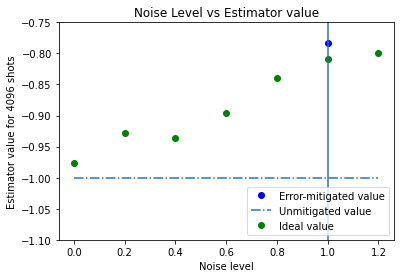

In [274]:
xrange = np.linspace(0, max(lmbdas), 100)
plt.ylim([-1.1, -.75])
mvs, = plt.plot(lmbdas, mitigated_values_scaling, 'go')
umv, = plt.plot(1.0, unmitigated_value, 'bo')
iv, = plt.plot(xrange, [-1]*len(xrange), '-.')
plt.xlabel("Noise level")
plt.ylabel("Estimator value for %s shots" %samples)
plt.axvline(1)
plt.title("Noise Level vs Estimator value")
plt.legend([umv, iv, mvs], ['Error-mitigated value', 'Unmitigated value', 'Ideal value'], loc="lower right")

## Tunable Noise

Another observation about this model is that each of the parameters can be tuned using the sampling method. Let
$$
\mathcal{L}_{\vec \lambda}(\rho) \equiv \sum_k \lambda_k(P_k\rho P_k-\rho)
$$
Since all of the terms in $\mathcal{L}_{\vec \lambda}$ and $\mathcal{L}_{\vec \phi}$ commute with each other,
$$
e^{\mathcal{L}_{\vec \lambda}}e^{\mathcal{L}_{\vec \phi-\vec \lambda}} = e^{\mathcal{L}_{\vec \lambda}}e^{-\mathcal{L}_{\vec \lambda}}e^{\mathcal{L}_{\vec \phi}} = e^{\mathcal{L}_{\vec \phi}}
$$
The map $\Lambda_{\vec \phi-\vec \lambda} = e^{\mathcal{L}_{\vec \phi-\vec \lambda}}$ can be implemented to produce a noise model with individually tuned parameters. The product form is just as before:
$$
\Lambda_{\vec \phi-\vec \lambda}(\rho) = \prod_k \frac{1}{2}(1+e^{2(\lambda_k-\phi_k)})\rho - \frac{1}{2}(1-e^{2(\lambda_k-\phi_k)})P_k\rho P_k
$$
Each of the terms can be scaled individually to give a QPD, resulting in the overhead
$$
\gamma = \prod_{\{k \ | \ \phi_k < \lambda_k\}} e^{2(\lambda_k-\phi_k)} = e^{2\sum_{k \ | \ \phi_k < \lambda_k}\lambda_k}
$$
The procedure for sampling is as follows:
1. Start with the identity map
2. If $\lambda_k > \phi_k$ then...
    1. Sample the identity with probability $\frac{1}{2}(1+e^{-2(\lambda_k-\phi_k)})$ and $P_k$ otherwise
    2. Compose the map into the operator to be applied
    3. Multiply $e^{2(\lambda_k-\omega_k)}$ into the scale factor
    4. If $P_k$ was chosen, then multiply $-1$ in to the scale factor
3. If $\lambda_k < \phi_k$ then...
    1. Sample the identity with probability $\frac{1}{2}(1+e^{2(\lambda_k-\phi_k)})$ and $P_k$ otherwise
    2. Compose the map into the operator to be applied
    4. Run the circuit and don't scale the result
4. Add all of the scaled runs together and average

In [250]:
def noise_tuning(target_coeffs, samples, ideal_circuit, measured_coeffs, backend, noise_model):
    circuits = []
    scale_factors = []
    
    adjusted_omegas = []
    overhead = 1
    for (lambdak, phik) in zip(measured_coeffs, target_coeffs):
        if lambdak - phik > 0:
            adjusted_omegas.append(.5*(1+math.exp(-2*(lambdak-phik))))
            overhead *= math.exp(2*(lambdak-phik))
        else:
            adjusted_omegas.append(.5*(1+math.exp(2*(lambdak-phik))))
    
    for j in range(samples):
        scale_factor = 1 #m keeps track of the sign, with paulis carrying a negative sign
        qc = ideal_circuit.copy()
        op = Pauli('I')
        for i in range(len(pauli_list)):
            #with probability 1-\omega_k, sample the Pauli gate and compose into operator
            diff_coeff = measured_coeffs[i]-target_coeffs[i]
            if diff_coeff > 0:
                scale_factor *= math.exp(2*diff_coeff)
            if rand() < 1-adjusted_omegas[i]:
                if diff_coeff > 0:
                    scale_factor *= -1
                op = op.compose(T[i]) #Wow I spent so long on this silly line
        qc.barrier()
        qc.append(op.to_instruction(),[0])
        qc.barrier()
        qc.measure(0,0)
        circuits.append(qc)  
        scale_factors.append(scale_factor)
    
    job = execute(circuits, backend, noise_model = noise_model, basis_gates = noise_model.basis_gates, shots = 1)
    
    total = 0
    for (count,scale) in zip(job.result().get_counts(),scale_factors):
        total += expectation(count)*scale

    mitigated_value = total/samples
    
    return mitigated_value, overhead

To test out the parameter tuning, I ran the mitigation scheme with several target parameter sets, and then ran normal circuits with a noise model generated from the target parameters

In [271]:
samples = 4096
noise_model = pe.build_noise_model(F, T, coeffs, n)

target_coeffs = [.1, 0, 0]
mitigated_value_x, overhead_x = noise_tuning(target_coeffs, samples, ideal_circuit, unzip(measured_coeffs), backend, noise_model)

target_coeffs = [0, .1, 0]
mitigated_value_y, overhead_y = noise_tuning(target_coeffs, samples, ideal_circuit, unzip(measured_coeffs), backend, noise_model)

target_coeffs = [0, 0, .1]
mitigated_value_z, overhead_z = noise_tuning(target_coeffs, samples, ideal_circuit, unzip(measured_coeffs), backend, noise_model)

In [272]:
ideal_circuit = QuantumCircuit(qr, cr)
ideal_circuit.x(0)
ideal_circuit.measure(0,0); #expectation value 
ideal_circuit.draw()

noise_model = pe.build_noise_model(F, T, [.1, 0, 0], n)
job = execute(ideal_circuit, backend, noise_model = noise_model, basis_gates = noise_model.basis_gates, shots=10000)
unmitigated_value_x = expectation(job.result().get_counts())

noise_model = pe.build_noise_model(F, T, [0, .1, 0], n)
job = execute(ideal_circuit, backend, noise_model = noise_model, basis_gates = noise_model.basis_gates, shots=10000)
unmitigated_value_y = expectation(job.result().get_counts())

noise_model = pe.build_noise_model(F, T, [0, 0, .1], n)
job = execute(ideal_circuit, backend, noise_model = noise_model, basis_gates = noise_model.basis_gates, shots=10000)
unmitigated_value_z = expectation(job.result().get_counts())

Text(0.5, 1.0, 'Comparison of tuned channel with equivalent error channel')

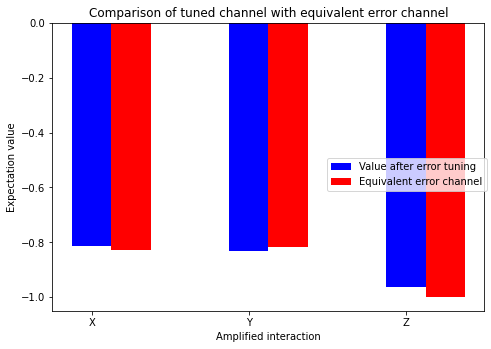

In [273]:
data = [[mitigated_value_x, mitigated_value_y, mitigated_value_z],
[unmitigated_value_x, unmitigated_value_y, unmitigated_value_z]]
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xticks(X, ('X', 'Y', 'Z'))
mitigated_bar = ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
unmitigated_bar = ax.bar(X + 0.25, data[1], color = 'r', width = 0.25)
fig.legend([mitigated_bar, unmitigated_bar], ["Value after error tuning", "Equivalent error channel"], loc="center right")
plt.xlabel("Amplified interaction")
plt.ylabel("Expectation value")
plt.title("Comparison of tuned channel with equivalent error channel")